In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb

import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# Set random seed
np.random.seed(1)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/CLPS 1291/Copy of hals_biomarker_ld_07dec23 - Cols Deleted and Preprocessed - Empty items filled with average.csv')

trait_names = list(data.columns)
trait_data = data.iloc[0:].values

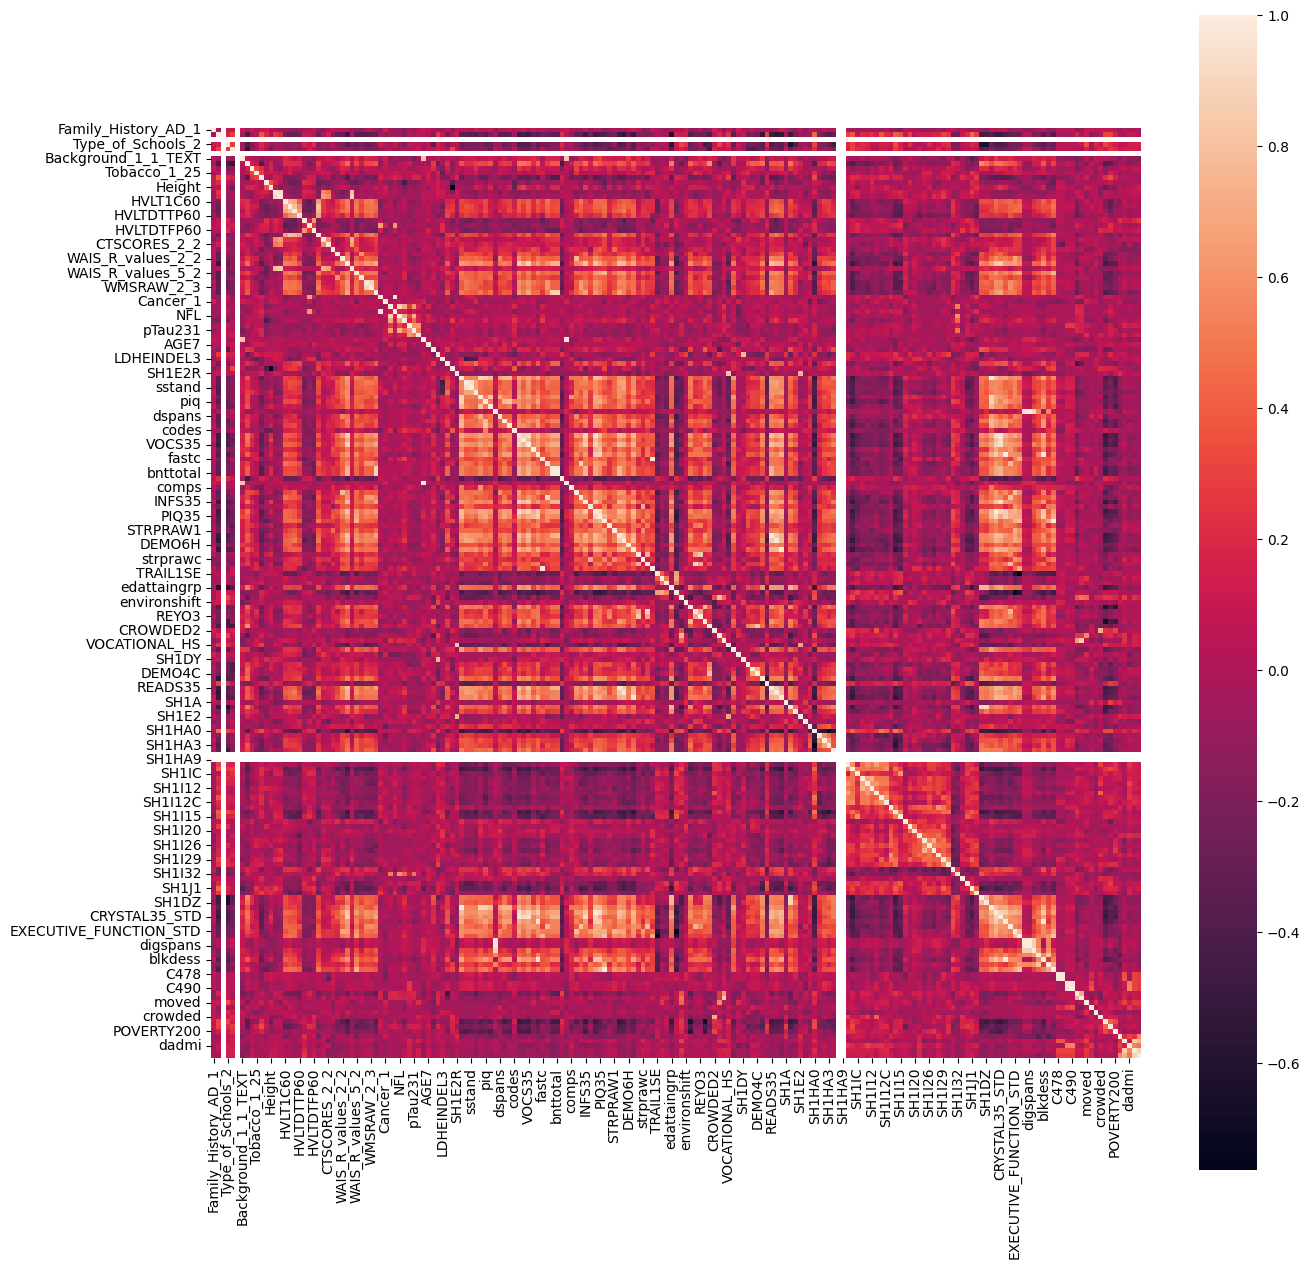

In [5]:
cor_mat = data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(cor_mat, square = True)
plt.show()

In [6]:
from sklearn.preprocessing import normalize
# split train test dataset

dependent_variables = ["Ab40",	"Ab42",	"NFL",	"GFAP",	"pTau181",	"pTau231",	"pTau217"]

X = data.drop(dependent_variables, axis = 1)
y = data[dependent_variables[0]]
y = y.drop(97)
X = X.drop([97])
x_var = list(X.columns.values)
X = normalize(X, axis=0, norm='l2')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_train).astype('float32')), torch.from_numpy(np.array(y_train).astype('float32')))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(np.array(X_test).astype('float32')), torch.from_numpy(np.array(y_test).astype('float32')))

In [8]:
# Set batch size (the number of samples used at a time to train) to 8 for now
batch_size = 8

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=2)

In [9]:
# create model

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(188, 128)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(128, 32)
    self.relu = nn.ReLU()
    self.linear3 = nn.Linear(32, 8)
    self.relu = nn.ReLU()
    self.linear4 = nn.Linear(8, 1)

  def forward(self, x):
    out0 = self.flatten(x)
    out1 = self.linear1(out0)
    out2 = self.relu(out1)
    out3 = self.linear2(out2)
    out4 = self.relu(out3)
    out5 = self.linear3(out4)
    out6 = self.relu(out5)
    out7 = self.linear4(out6)
    return out7

model = NeuralNetwork().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
adam_optimizer = optim.SGD(model.parameters(), lr=0.0005)
from torchsummary import summary
summary(model, (1, 188))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 188]               0
            Linear-2                  [-1, 128]          24,192
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 32]           4,128
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 8]             264
              ReLU-7                    [-1, 8]               0
            Linear-8                    [-1, 1]               9
Total params: 28,593
Trainable params: 28,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


In [10]:
from sklearn.metrics import mean_squared_error

epochs = 10
val_MSE = []

model = model.cuda()

for epoch in range(epochs):
  total_loss = 0
  for (batch_X, batch_y) in trainloader:
    # Zero the gradients
    adam_optimizer.zero_grad()
    # Forward pass
    outputs = model(batch_X.cuda())
    # Compute the loss
    loss = criterion(outputs, batch_y.cuda())
    # Backward pass
    loss.backward()
    # Update weights
    adam_optimizer.step()
    total_loss += loss.item()
  # Print average loss for the epoch
  print(f"Epoch {epoch + 1}, Loss: {total_loss / len(trainloader):.4f}")

  # Validation
  model.eval()
  with torch.no_grad():
    val_mse = []

    for (batch_X, batch_y) in testloader:
      val_outputs = model(batch_X.cuda())
      val_loss = criterion(val_outputs, batch_y.cuda())
      mse = mean_squared_error(val_outputs.cpu(), batch_y)
      val_mse.append(mse)
    val_MSE.append(np.mean(val_mse))

  print(f"Validation Loss: {val_loss.item():.4f}, Validation MSE: {np.mean(val_mse):.4f}")

Epoch 1, Loss: 9859.9056
Validation Loss: 8769.8770, Validation MSE: 9838.3555
Epoch 2, Loss: 7694.5087
Validation Loss: 8424.8076, Validation MSE: 9472.3330
Epoch 3, Loss: 6258.4564
Validation Loss: 5093.9121, Validation MSE: 4507.9570
Epoch 4, Loss: 1413.4898
Validation Loss: 1857.2595, Validation MSE: 2358.8115
Epoch 5, Loss: 737.3261
Validation Loss: 723.4615, Validation MSE: 669.1269
Epoch 6, Loss: 526.2918
Validation Loss: 526.0923, Validation MSE: 709.2856
Epoch 7, Loss: 460.6573
Validation Loss: 1120.9760, Validation MSE: 964.3157
Epoch 8, Loss: 487.0261
Validation Loss: 3594.1460, Validation MSE: 3115.7366
Epoch 9, Loss: 880.4441
Validation Loss: 621.7885, Validation MSE: 858.6409
Epoch 10, Loss: 595.1343
Validation Loss: 517.8599, Validation MSE: 694.6025


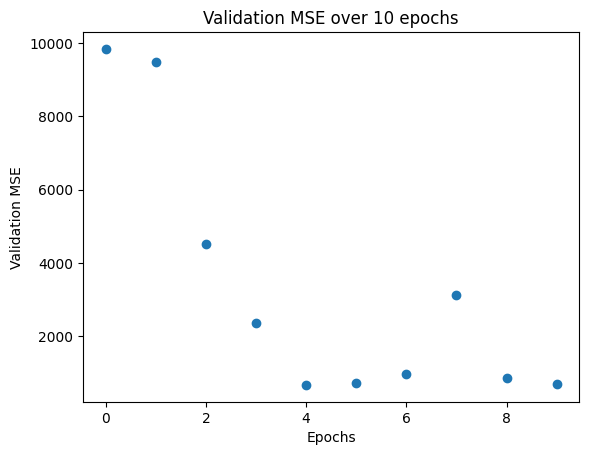

In [11]:
plt.scatter(np.arange(0, 10), val_MSE)
plt.title("Validation MSE over 10 epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.show()